In [194]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

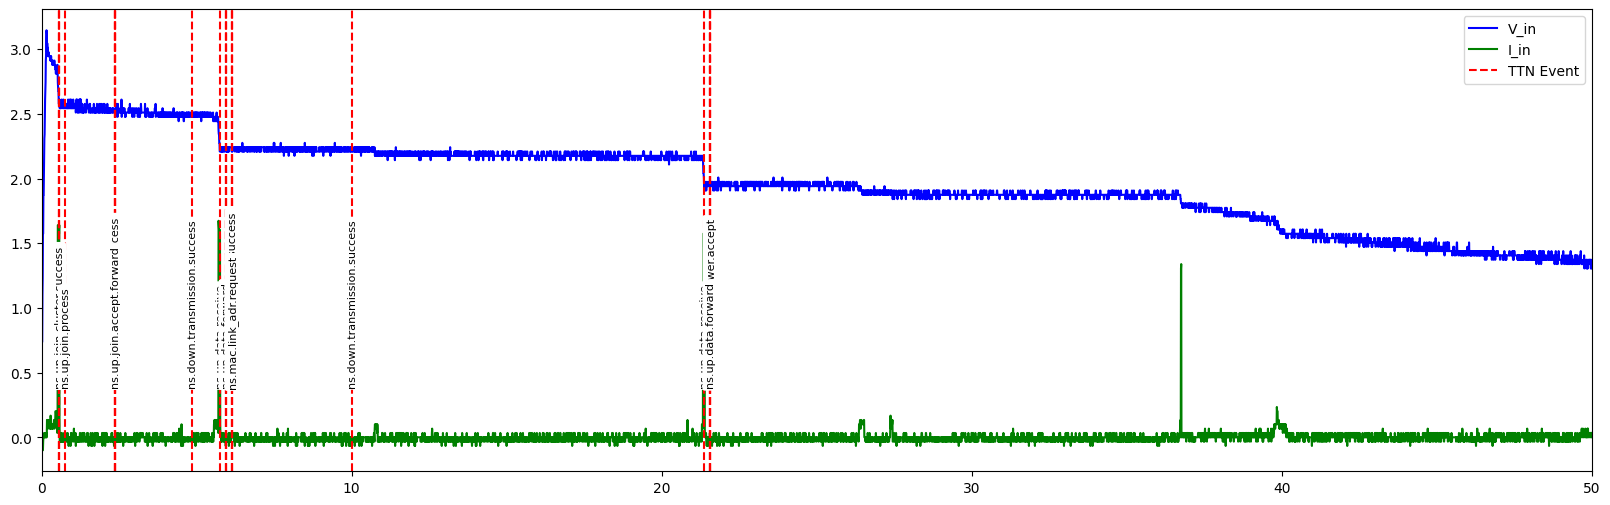

In [195]:
#################################################
#                                               #
#                   TTN Overlay                 #
#                                               #
#################################################

# Note: time logs in TTN have an offset from the scope data which isn't time-stamped (only relative to starting point)

file = '220ms_40mF1'
lower_limit = 0
upper_limit = 50
offset = 0.55

scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

plt.figure(figsize=(20, 6))
plt.plot(scope_data['second'], scope_data['V_in'], color='b', label="V_in")
plt.plot(scope_data['second'], scope_data['I_in'], color='g', label="I_in")

ttn_json = open('./TTN/{}.json'.format(file))
ttn_logs = json.load(ttn_json)
ttn_logs.reverse()
if ttn_logs[0]['name'] == 'synthetic.status.cleared':
    ttn_logs = ttn_logs[1:]
ttn_json.close()

events = []
timestamps = []
reference_time = datetime.fromisoformat(ttn_logs[0]['time'])
for log in ttn_logs:
    events.append(log['name'])
    time_elapsed = (datetime.fromisoformat(log['time']) - reference_time).total_seconds()
    timestamps.append(time_elapsed)

for timestamp, event in zip(timestamps, events):
    time = timestamp+offset
    line = plt.axvline(x=time, color='r', linestyle='--')
    plt.annotate(event, xy=(time, 0), xytext=(time, 0.4), color='black', ha='center', fontsize=8,
        rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))
plt.plot([], [], color='r', linestyle='--', label='TTN Event')

plt.xlim(lower_limit, upper_limit)
plt.legend(loc='upper right')
plt.show()

In [197]:
#################################################
#                                               #
#           Determining Window Bounds           #
#                                               #
#################################################

def get_bounds(file):

    extend = 1      # Expand windows found this many in either direction to contain events better
    scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

    transmission_windows = []
    rx_windows = []

    def check_valid(element, list, skip=None):   # Returns False if no problems
        if element[1] - element[0] < 3:    # Don't allow overly small windows
            return True
        if skip != None:    # Skip the overlay check
            return True
        overlap = False     # Don't allow RX and transmission windows to coincide
        element_start, element_end = element
        for window in list:
            window_start, window_end = window
            if not (element_end < window_start or element_start > window_end):
                overlap = True
                break
        return overlap

    # Get transmission windows

    start_index = None
    for index, val in enumerate(scope_data['I_in']):
        if val > 1.4:
            if start_index is None:
                start_index = index
        else:
            if start_index is not None:
                window = (start_index - extend, index - 1 + extend)
                if not check_valid(window, transmission_windows):
                    transmission_windows.append(window)
                start_index = None
    if start_index is not None:
        window = (start_index - extend, len(scope_data['I_in']) - 1)
        if not check_valid(window, transmission_windows):
            transmission_windows.append(window)
    transmission_windows = transmission_windows[1:]

    # Return empty lists if transmission never successfully occurred

    if len(transmission_windows) == 0:
        return [[], []]

    # Get RX windows

    start_index = None
    for index, val in enumerate(scope_data['I_in']):
        if index < transmission_windows[0][0] or index > transmission_windows[-1][1] + 900:  # Skip anything before the first transmission and more than ~15s after last transmission
            continue
        if val > 0.07 and val < 0.2:
            if start_index is None:
                start_index = index
        else:
            if start_index is not None and val < 0.03:
                window = (start_index - extend, index - 1 + extend)
                if not check_valid(window, transmission_windows):
                    rx_windows.append(window)
                start_index = None
    if start_index is not None:
        window = (start_index - extend, len(scope_data['I_in']) - 1)
        if not check_valid(window, transmission_windows):
            rx_windows.append(window)

    return [transmission_windows, rx_windows]

def plot_bounds(file, windows, limits=None):

    scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

    plt.figure(figsize=(20, 3))
    plt.plot(scope_data['second'], scope_data['I_in'], color='g', label="I_in")
    plt.plot(scope_data['second'], scope_data['V_in'], color='b', label="V_in")

    transmission_windows, rx_windows = windows

    for window in transmission_windows:
        for index in window:
            timestamp = scope_data['second'].iloc[index]
            plt.axvline(x=timestamp, color='r', linestyle='--')
            plt.annotate(timestamp, xy=(timestamp, 0), xytext=(timestamp, 0.5), color='black', ha='center', fontsize=8,
                rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

    for window in rx_windows:
        for index in window:
            timestamp = scope_data['second'].iloc[index]
            plt.axvline(x=timestamp, color='orange', linestyle='--')
            plt.annotate(timestamp, xy=(timestamp, 0), xytext=(timestamp, 0.5), color='black', ha='center', fontsize=8,
                rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.plot([], [], color='r', linestyle='--', label='Transmission')
    plt.plot([], [], color='orange', linestyle='--', label='RX')
    plt.title('{} Windows of Operation'.format(file))
    plt.legend(loc='upper right')
    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Voltage Measurement (V)')

    if limits != None:
        plt.xlim(limits[0], limits[1])

    plt.show()

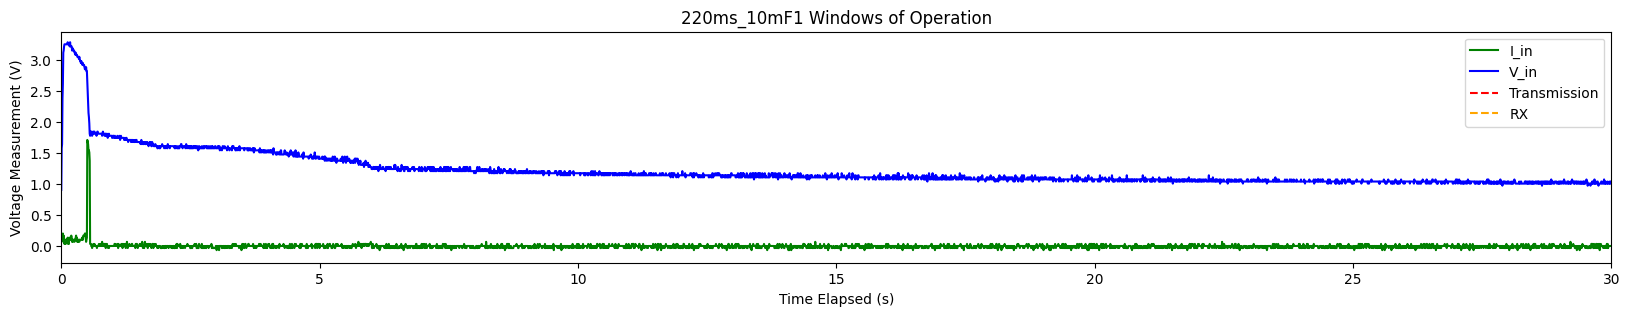

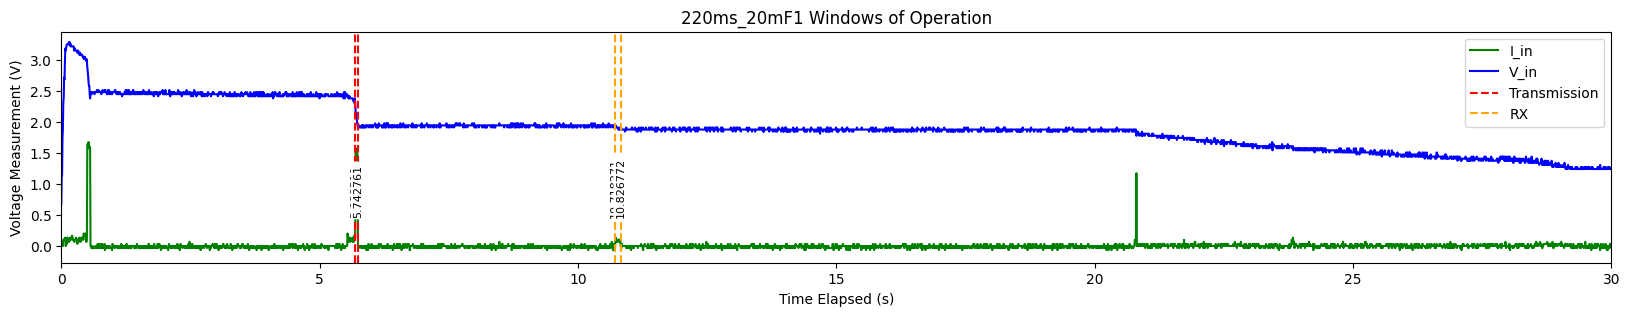

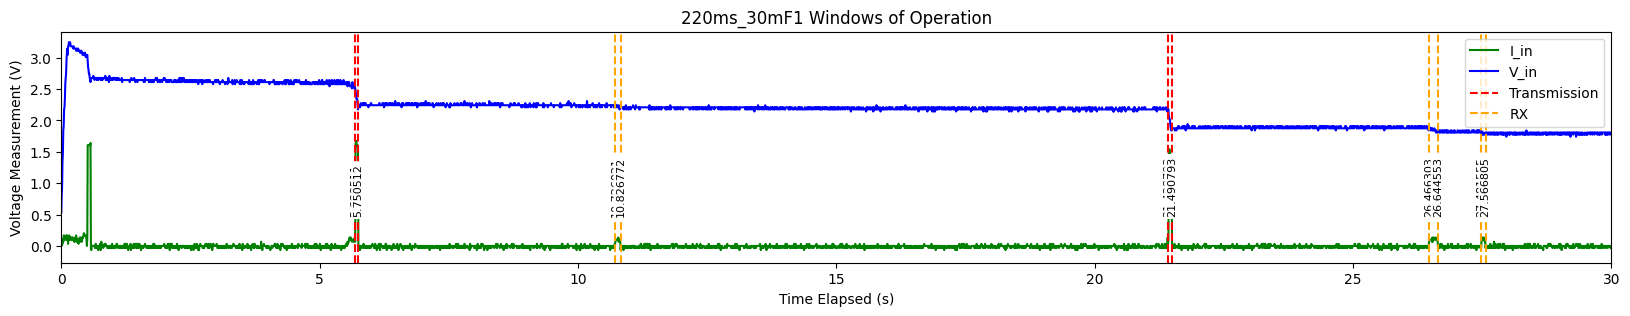

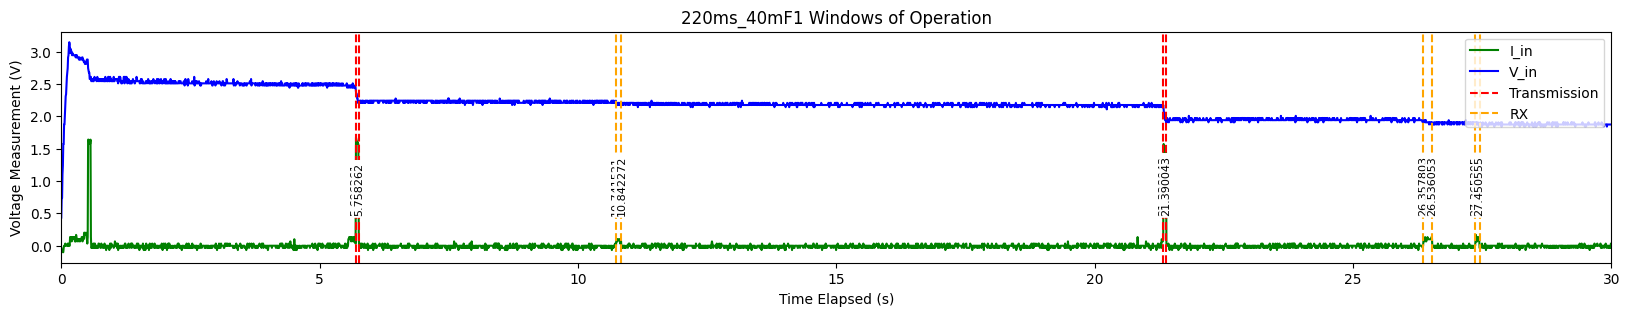

In [198]:
#################################################
#                                               #
#         Plot all C of one Pulse Length        #
#                                               #
#################################################

ms = 220
file = '{}ms_10mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])
file = '{}ms_20mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])
file = '{}ms_30mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])
file = '{}ms_40mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])

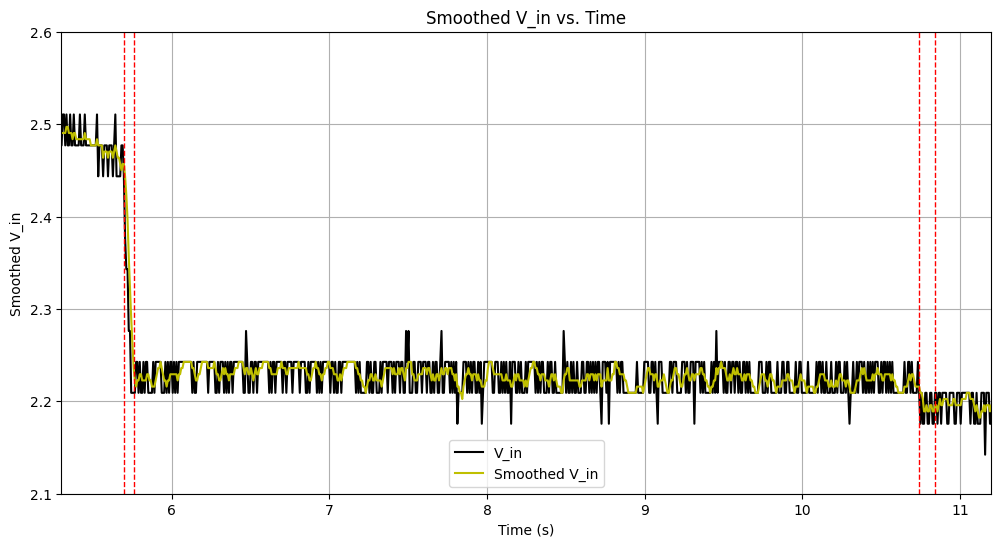

In [202]:
#################################################
#                                               #
#           Prepare for Optimization            #
#                                               #
#################################################

ms = 220
C = 0.040
R_shunt = 1.071
initial_voltage = 0

file = '{}ms_{}mF1'.format(ms, int(C*1000))
transmission_windows, rx_windows = get_bounds(file)
scope_data = pd.read_csv('./Scope/{}.csv'.format(file))
V_in = scope_data['V_in']
seconds = scope_data['second']

# Get ranges of each RX and TX window
window_indices = []
for start, end in transmission_windows + rx_windows:
    window_indices.extend([start, end])
window_indices.sort()

# Defining models for optimization and smoothing
def model(t, R):
    return initial_voltage * np.exp(-t / (R * C))

def model_linear(t, m):
    return initial_voltage + m*t

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth the data (if you want, put window_size > 1)
window_size = 5
smoothed_V_in = moving_average(V_in, window_size=window_size)
adjusted_seconds = seconds[window_size-1:]

# Plot smoothed_V_in vs adjusted_seconds
plt.figure(figsize=(12, 6))
plt.plot(seconds, V_in, color='black', label="V_in")
plt.plot(adjusted_seconds, smoothed_V_in, color='y', label="Smoothed V_in")
plt.xlim(5.3, 11.2)
plt.ylim(2.1, 2.6)
plt.xlabel('Time (s)')
plt.ylabel('Smoothed V_in')
plt.title('Smoothed V_in vs. Time')
plt.grid(True)

for index in window_indices:
    plt.axvline(x=seconds[index], color='r', linestyle='--', linewidth=1)

plt.legend()
plt.show()

In [210]:
#################################################
#                                               #
#                   Fit Models                  #
#                                               #
#################################################

# Fit the model to the data between each pair of consecutive indices in adjusted_window_indices
optimal_Req_values, optimal_m_values = [], []
for i in range(0, len(window_indices)-1):
    initial_voltage = smoothed_V_in[window_indices[i]]
    start, end = window_indices[i], window_indices[i + 1] - 1
    t = adjusted_seconds[start:end+1].reset_index(drop=True) - adjusted_seconds[start]
    V = smoothed_V_in[start:end+1]
    initial_guess = 10.0 
    params, _ = curve_fit(model, t, V, p0=initial_guess, bounds=(0, np.inf))
    optimal_Req_values.append(params[0])
    params_linear, _ = curve_fit(model_linear, t, V, p0=initial_guess, bounds=(-np.inf, np.inf))
    optimal_m_values.append(params_linear[0])

# Use the estimated model to get estimations of V_in at each timestep
estimations, estimations_linear = [], []
times = []
for i in range(0, len(window_indices)-1):
    initial_voltage = smoothed_V_in[window_indices[i]]
    start, end = window_indices[i], window_indices[i + 1] - 1
    t = adjusted_seconds[start:end+1] - adjusted_seconds[start]
    V = smoothed_V_in[start:end+1]
    estimations.extend(model(t, optimal_Req_values[i]))
    times.extend(t + adjusted_seconds[start])
    estimations_linear.extend(model_linear(t, optimal_m_values[i]))
    
# Calculate and plot the mean squared error
mse = mean_squared_error(smoothed_V_in[:len(estimations)], estimations)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) - Exponential Model: {rmse}")

mse_linear = mean_squared_error(smoothed_V_in[:len(estimations_linear)], estimations_linear)
rmse_linear = np.sqrt(mse_linear)
print(f"Root Mean Squared Error (RMSE) - Linear Model: {rmse_linear}")

# Pring the estimated R values
print("\nOptimal Req values:")
for i, Req in enumerate(optimal_Req_values):
    print(f"Window {i+1}: {Req}")

Root Mean Squared Error (RMSE) - Exponential Model: 0.21899211287634304
Root Mean Squared Error (RMSE) - Linear Model: 0.21674576641301022

Optimal Req values:
Window 1: 35.006633706726525
Window 2: 245600.0
Window 3: 5120.0
Window 4: 14391.758431123848
Window 5: 29.647623891154986
Window 6: 245600.0
Window 7: 275.2197972930221
Window 8: 61420.0
Window 9: 173.2757349356875


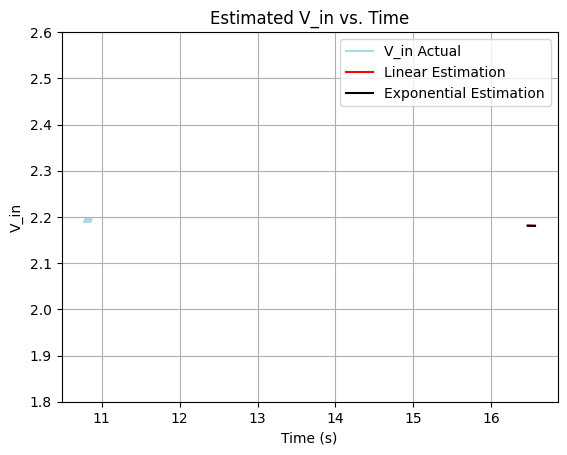

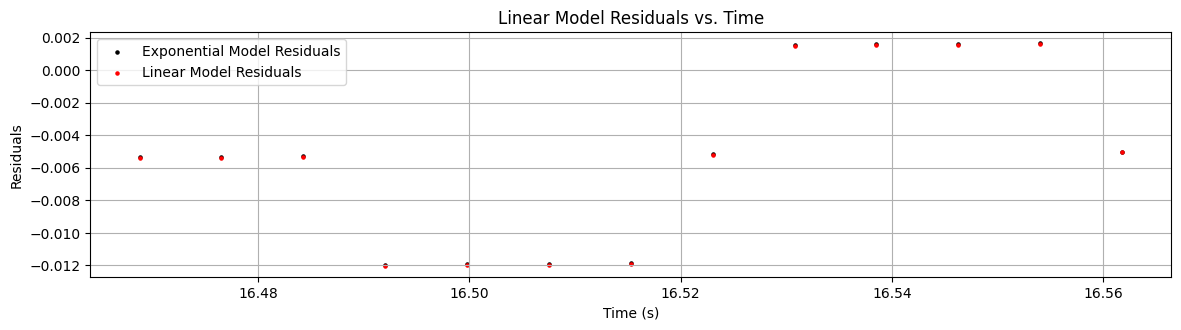

In [214]:
#################################################
#                                               #
#               Plot Model Results              #
#                                               #
#################################################

isolate_window = 2
window_start = window_indices[isolate_window]
window_end = window_indices[isolate_window+1]

# Plot the estimated model and the actual voltage readings
plt.plot(adjusted_seconds[window_start:window_end], smoothed_V_in[window_start:window_end], color='lightblue', label="V_in Actual")
plt.plot(times[window_start:window_end], estimations_linear[window_start:window_end], color='red', label="Linear Estimation", zorder=2, linestyle='-')
plt.plot(times[window_start:window_end], estimations[window_start:window_end], color='black', label="Exponential Estimation", zorder=2, linestyle='-')
# plt.xlim(5, 30)
plt.ylim(1.8, 2.6)
plt.xlabel('Time (s)')
plt.ylabel('V_in')
plt.title('Estimated V_in vs. Time')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and plot residuals
residuals = smoothed_V_in[window_indices[0]:window_indices[-1]] - estimations
residuals_linear = smoothed_V_in[window_indices[0]:window_indices[-1]] - estimations_linear
plt.figure(figsize=(12, 6))

# Plot residuals for the exponential model
plt.subplot(2, 1, 1)
plt.scatter(times[window_start:window_end], residuals[window_start:window_end], color='black', label='Exponential Model Residuals', s=5)
plt.xlabel('Time (s)')
plt.ylabel('Residuals')
plt.title('Exponential Model Residuals vs. Time')
plt.legend()
plt.grid(True)

# Plot residuals for the linear model
plt.subplot(2, 1, 1)
plt.scatter(times[window_start:window_end], residuals_linear[window_start:window_end], color='red', label='Linear Model Residuals', s=5)
plt.xlabel('Time (s)')
plt.ylabel('Residuals')
plt.title('Linear Model Residuals vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()